# CRM using Simpy - Refactor

Refactor previous code with a structured message between agents to allow standardised control and logging

- json_msg in json format{"suid": str, "ruid": str, "intent": str, "action": str, "payload": str}
    - suid: sender unique id
    - ruid: receiver unique id
    - intent: the intent of the message (e.g., "email campaign", "submit bid")
    - action: the action to be performed (e.g., "request", "accept", "decline")
- in each agent, json_msg is parsed into a dictionary
- agent maps the "intent" to a handler_process_method
- agent calls the handler_process_method with msg dictionay as parameter

In [1]:
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import simpy

from abc import ABC, abstractmethod
from datetime import datetime, timedelta
from eccore.ipython import nb_setup
from eccore.core import setup_logging, logthis
from enum import Enum
from pathlib import Path
from pprint import pprint
from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple
from uuid import uuid4
from functools import partial


p2log = Path('../logs/sim.log').resolve()
p2log.touch(exist_ok=True)
assert p2log.is_file()
setup_logging(logfile=p2log)
nb_setup()

from agents import BaseAgent, MarketingDpt, SalesRep, Account # type: ignore
from crm import CustomerRelationManagerSimulator # type: ignore
from enums import AccountStatus, AccountType, AccountStage, Country, Industry, LeadSource # type: ignore
from enums import MktgIntents, SalesIntents, Actions # type: ignore
# from enums import MarketingMessages, SalesRepMessages, SalesRejectionMessages, OpsMessages # type: ignore
from utils import account_info_generator, salesrep_name_generator # type: ignore

# random.seed(1988)

Logging to console and to /home/vtec/projects/diyai/crm-sim/logs/sim.log.
Logging setup finished
Added path: /home/vtec/projects/diyai/crm-sim/src
Set autoreload mode


In [2]:
crm = CustomerRelationManagerSimulator()
crm.populate(   
    nb_salesreps=4,
    nb_mql=100,
    nb_sql=100,
    nb_others=0
)

with open(p2log, 'w') as f:
# with open(p2log, 'a') as f:
    f.write(f"{'='* 100}\n")
    f.write(f"New Simulation {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"{'='* 100}\n")

crm.run(until=100)

Retrieving CRM
Created 100 MQL accounts
Created 100 SQL accounts
Total accounts created: 200


In [3]:
crm.account_df().head()

,account_type,assigned_salesrep,country,cumulative_opportunity_value,cumulative_purchase_value,industry,lead_source,name,nb_opportunities,nb_purchases,stage,uid
0,MEDIUM,srep-d45528cc-d5f6-4370-8f84-75b4f634e276,EU,0,0,Chemicals,EXISTING_CUSTOMER,MonsPac NV,0,0,MQL,acct-696b56db-235d-43d4-af82-4ad075f9f343
1,SMALL,srep-d45528cc-d5f6-4370-8f84-75b4f634e276,EU,0,0,FoodnBeverage,WEBSITE_CTA,TurinFlex S.p.A.,0,0,MQL,acct-46d15015-c0ac-44d2-aeb6-e7ae654d14b6
2,SMALL,srep-d45528cc-d5f6-4370-8f84-75b4f634e276,EU,0,0,ConsumerGoods,WEBSITE_CTA,HeidelbergPack GmbH,0,0,SQL,acct-580388b7-b91c-4b1c-ab94-4ca67e5ca900
3,SMALL,srep-d45528cc-d5f6-4370-8f84-75b4f634e276,EU,0,0,FoodnBeverage,WEBSITE_CTA,FlorenceFlex S.p.A.,0,0,MQL,acct-b798356d-98a6-45ef-9aff-d407fbcdd5d1
4,SMALL,srep-d45528cc-d5f6-4370-8f84-75b4f634e276,CN,0,0,Pharmaceuticals,EXISTING_CUSTOMER,"JiaxingWrap Co., Ltd.",0,0,SQL,acct-2a540297-e502-4306-bec7-e062daef26dd


In [4]:
crm.salesrep_df()

,name,uid
0,SalesRep 1,srep-d45528cc-d5f6-4370-8f84-75b4f634e276
1,SalesRep 2,srep-e14fc11d-ecf5-415c-afbd-1d9d05ea9ed2
2,SalesRep 3,srep-b69f8e93-629d-4083-a52c-1833539e95f4
3,SalesRep 4,srep-f8d9726b-6125-4bf8-b2d3-eb8af359c5f7


In [5]:
df = crm.account_stats_to_df()
df

,nb_accounts,LEAD,MQL,SQL,PROSPECT,PITCHED,BIDDED,SIGNED,ACTIVE,STALE
timestamp,,,,,,,,,,
2026-01-12,200,0,97,97,6,0,0,0,0,0
2026-01-19,202,0,99,94,9,0,0,0,0,0
2026-01-26,203,0,100,90,13,0,0,0,0,0
2026-02-02,203,0,99,90,13,1,0,0,0,0
2026-02-09,204,0,100,84,17,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2027-11-01,259,0,106,115,20,5,3,8,0,2
2027-11-08,259,0,106,116,21,3,3,8,0,2
2027-11-15,259,0,106,116,20,5,2,8,0,2


In [6]:
df = crm.transactions_to_df()
df
df.action.unique()
# df.loc[df.intent == SalesIntents.USER_NEED.value, :]
# df.loc[df.intent == SalesIntents.USER_NEED.value, :].loc[df.sender.str.startswith('acct'), :]
df.loc[df.sender.str.startswith('acct'), :]

,sender,receiver,intent,action,type,value
timestamp,,,,,,
2026-01-07 02:24:00,acct-8c854d43-43f5-4d83-a319-9fc9cfb6fe3f,srep-b69f8e93-629d-4083-a52c-1833539e95f4,user need discovery,accept,external,NaN
2026-01-07 02:24:00,acct-4eb531d2-6ce8-4ba8-accf-086c1ae1eaba,srep-f8d9726b-6125-4bf8-b2d3-eb8af359c5f7,user need discovery,accept,external,NaN
2026-01-07 02:24:00,acct-d772daa1-5570-426b-b6b3-2189e20d6c08,srep-d45528cc-d5f6-4370-8f84-75b4f634e276,user need discovery,accept,external,NaN
2026-01-07 02:24:00,acct-18ffb4bc-44ca-426c-929a-8ab158089e15,srep-e14fc11d-ecf5-415c-afbd-1d9d05ea9ed2,user need discovery,reject,external,NaN
2026-01-07 02:24:00,acct-38b506cb-aac9-4d11-a1f2-9064acb555e5,srep-d45528cc-d5f6-4370-8f84-75b4f634e276,user need discovery,accept,external,NaN
...,...,...,...,...,...,...
2027-12-05 07:12:00,acct-91e473fa-c804-4504-95b6-6bb0155e5d81,mktg-dd324d49-66bd-4b8c-88b7-de3027ec9748,email campaign,reject,external,NaN
2027-12-05 07:12:00,acct-afc55292-0fb0-4163-8717-b2db4153e00a,mktg-dd324d49-66bd-4b8c-88b7-de3027ec9748,email campaign,reject,external,NaN
2027-12-05 07:12:00,acct-b99f8d81-69a2-4459-b2db-17ec61fe292a,mktg-dd324d49-66bd-4b8c-88b7-de3027ec9748,email campaign,reject,external,NaN


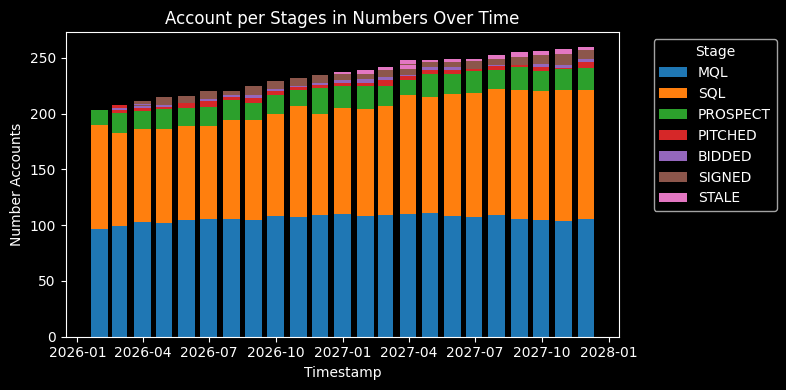

In [7]:
crm.plot_account_stats(as_share=False, hide_mql=False, hide_mql_sql=False)

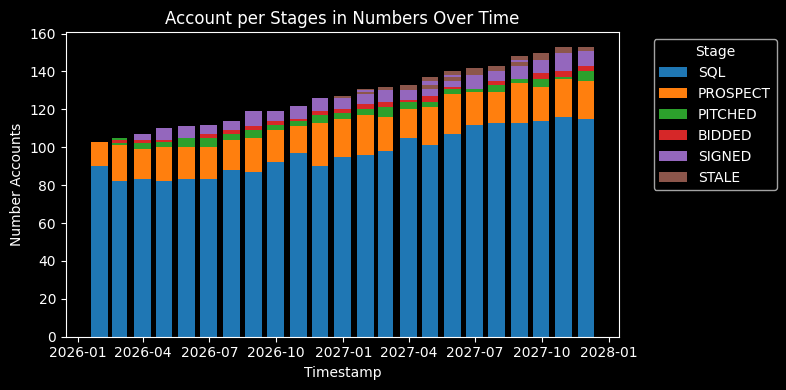

In [8]:
crm.plot_account_stats(as_share=False, hide_mql=True, hide_mql_sql=False)

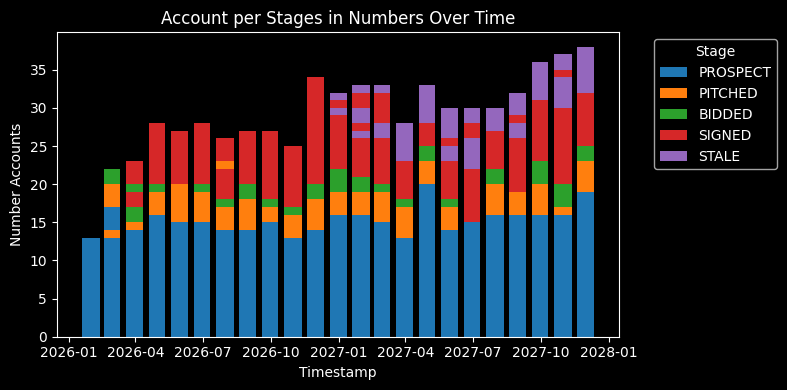

In [9]:
crm.plot_account_stats(as_share=False, hide_mql=True, hide_mql_sql=True)

In [12]:
df = crm.transactions_to_df()
nb_weeks = int((df.index[-1] - df.index[0]).total_seconds() /60/60/24/7)
print(f"Simulation ran for {nb_weeks:d} weeks")
df.loc[df.action == 'transition',:].intent.unique()

Simulation ran for 99 weeks


array(['SQL to PROSPECT', 'SQL to SQL', 'MQL to SQL', 'PROSPECT to SQL',
       'PROSPECT to PITCHED', 'PITCHED to SQL', 'PITCHED to BIDDED',
       'BIDDED to SQL', 'BIDDED to SIGNED', 'SIGNED to PROSPECT',
       'SIGNED to STALE'], dtype=object)

In [13]:
coi = [
    # 'MQL to SQL',
    'SQL to PROSPECT', 
    'SQL to SQL', 
    'PROSPECT to PITCHED', 
    'PROSPECT to SQL', 
    'PITCHED to BIDDED', 
    'PITCHED to SQL',
    'BIDDED to SIGNED',
    'BIDDED to SQL',
    'SIGNED to PROSPECT', 
    'SIGNED to STALE'
       ]
coi_success = [
    # 'MQL to SQL',
    'SQL to PROSPECT', 
    'PROSPECT to PITCHED', 
    'PITCHED to BIDDED', 
    'BIDDED to SIGNED',
    'SIGNED to PROSPECT', 
       ]
coi_fail = [
    # 'MQL to SQL',
    'SQL to SQL', 
    'PROSPECT to SQL', 
    'PITCHED to SQL',
    'BIDDED to SQL',
    'SIGNED to STALE'
       ]
transitions = df.loc[df.action == 'transition',:]
# transitions.groupby('intent').count().T.loc[['action'],coi].plot(kind='bar');

In [14]:
# success_failure = pd.concat([transitions.loc['action',coi_success], transitions.loc['action',coi_fail]],axis=0)
t_success = transitions.groupby(by='intent').count().T.loc[['action'],coi_success]
t_success.columns = 'SQL PROSPECT PITCHED BIDDED SIGNED'.split(' ')
t_fail = transitions.groupby(by='intent').count().T.loc[['action'],coi_fail]
t_fail.columns = 'SQL PROSPECT PITCHED BIDDED SIGNED'.split(' ')
success_fail = pd.concat([t_success, t_fail], axis=0)
success_fail.index = ['success', 'failed']
success_fail.loc['total', :] = success_fail.sum()
success_fail
# t_success

,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
success,1084.0,564.0,300.0,100.0,88.0
failed,516.0,566.0,258.0,198.0,4.0
total,1600.0,1130.0,558.0,298.0,92.0


In [15]:
reversed_cols = success_fail.columns[::-1]
success_fail.iloc[-1:,:]/len(crm.agents['salesrep'])/nb_weeks

,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
total,4.040404,2.853535,1.409091,0.752525,0.232323


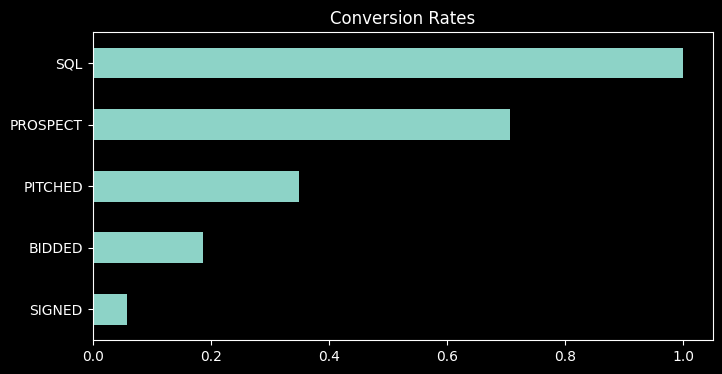

In [17]:
(success_fail.loc['total', reversed_cols] / success_fail.loc['total','SQL']).T.plot(kind='barh', figsize=(8, 4), title='Conversion Rates');

In [18]:
accts_ds = crm.account_df()
accts_ds.head()

[a.country for a in crm.agents['account']]

[<Country.EU: 1>,
 <Country.EU: 1>,
 <Country.EU: 1>,
 <Country.EU: 1>,
 <Country.CN: 2>,
 <Country.US: <class 'enum.auto'>>,
 <Country.CN: 2>,
 <Country.CN: 2>,
 <Country.EU: 1>,
 <Country.EU: 1>,
 <Country.EU: 1>,
 <Country.US: <class 'enum.auto'>>,
 <Country.EU: 1>,
 <Country.EU: 1>,
 <Country.CN: 2>,
 <Country.US: <class 'enum.auto'>>,
 <Country.EU: 1>,
 <Country.CN: 2>,
 <Country.US: <class 'enum.auto'>>,
 <Country.CN: 2>,
 <Country.EU: 1>,
 <Country.EU: 1>,
 <Country.EU: 1>,
 <Country.US: <class 'enum.auto'>>,
 <Country.EU: 1>,
 <Country.CN: 2>,
 <Country.EU: 1>,
 <Country.EU: 1>,
 <Country.CN: 2>,
 <Country.EU: 1>,
 <Country.EU: 1>,
 <Country.CN: 2>,
 <Country.EU: 1>,
 <Country.US: <class 'enum.auto'>>,
 <Country.CN: 2>,
 <Country.CN: 2>,
 <Country.EU: 1>,
 <Country.CN: 2>,
 <Country.US: <class 'enum.auto'>>,
 <Country.EU: 1>,
 <Country.EU: 1>,
 <Country.EU: 1>,
 <Country.EU: 1>,
 <Country.EU: 1>,
 <Country.US: <class 'enum.auto'>>,
 <Country.EU: 1>,
 <Country.CN: 2>,
 <Country.

In [19]:
transitions.head()

,sender,receiver,intent,action,type,value
timestamp,,,,,,
2026-01-07 02:24:00,crm-55d87bef-41c0-42d0-8fa4-8f100e203004,acct-8c854d43-43f5-4d83-a319-9fc9cfb6fe3f,SQL to PROSPECT,transition,system,NaN
2026-01-07 02:24:00,srep-b69f8e93-629d-4083-a52c-1833539e95f4,acct-8c854d43-43f5-4d83-a319-9fc9cfb6fe3f,SQL to PROSPECT,transition,internal,NaN
2026-01-07 02:24:00,crm-55d87bef-41c0-42d0-8fa4-8f100e203004,acct-4eb531d2-6ce8-4ba8-accf-086c1ae1eaba,SQL to PROSPECT,transition,system,NaN
2026-01-07 02:24:00,srep-f8d9726b-6125-4bf8-b2d3-eb8af359c5f7,acct-4eb531d2-6ce8-4ba8-accf-086c1ae1eaba,SQL to PROSPECT,transition,internal,NaN
2026-01-07 02:24:00,crm-55d87bef-41c0-42d0-8fa4-8f100e203004,acct-d772daa1-5570-426b-b6b3-2189e20d6c08,SQL to PROSPECT,transition,system,NaN


In [21]:
transitions_ds = pd.merge(left=transitions, right=accts_ds, how='left', left_on='receiver', right_on='uid').head()
transitions_ds.shape

(5, 18)

In [22]:
transitions_ds.groupby(by=['account_type', 'intent']).count().loc[:, ['action']]

,,action
account_type,intent,
LARGE,SQL to PROSPECT,2
MEDIUM,SQL to PROSPECT,1
SMALL,SQL to PROSPECT,2


#### Reference Conversion Rates

##### MQL
- website
    - nb mthly website visitor=2900 monthly
    - website cta rate=0.03
- email
    - online campaigns targets=1000 monthly
    - online campaigns clickthru=0.1
- industry event
    - nb industry events=1 quarterly
    - rawleads industry events=80 * nb industry events
- direct calls
    - rawleads salesreps=30 monthly (?)
- conversion 
    - rawlead2mql website=0.41
    - rawlead2mql online campaign=0.38
    - rawlead2mql industry event=0.3
    - salesrep leads2mql=0.02

##### SQL and later stages
- conversion
    - mql2sql=0.15
    - sql2prospect=0.7
    - prospect2prez=0.7
    - prez2bid=0.6
    - bid2close=0.3
    - customer satisfaction rate=0.98

- delays
    - mql2sql= 1 to 2 weeks
    - sql2prospect= 1 to 2 weeks
    - prospect2prez= 1 to 4 weeks
    - prez2bid= 2 to 12 weeks
    - bid2close= 2 to 12 weeks
    - customer project duration = 12 to 24 weeks


- decay rate=0.15

## Using in nb manual class definition

#### Define Enumerations

In [20]:
# class MktgIntents(Enum):
#     """Enum for all possible intents from Marketing to Accounts"""
#     EMAIL_CAMPAIGN = "email campaign"
#     INDUSTRY_EVENT = "industry event"

# class SalesIntents(Enum):
#     """Enum for all possible messages from SalesRep to Accounts"""
#     USER_NEED = "user need discovery"
#     PRESENTATION = "rv for presentation"
#     BID = "opportunity to bid"
#     NEGO = "negotiation"

# class Actions(Enum):
#     """Enum for all possible actions in the CRM"""
#     REQUEST = 'request'
#     ACCEPT = 'accept'
#     REJECT = 'reject'

#### Define Base Class for agents

In [21]:
# class BaseAgent(ABC):
#     """Base Agent class, used to create any other agent in the CRM simulation

#     Provides the following functionalities:
#     - inbox for receiving messages
#     - message handling
#     - handle processes based on intent in incoming messages.
#     """

#     _category = "baseagent" 
    
#     def __init__(self, crm):
#         self.crm = crm
#         # Define aliases for convenience
#         self.env = self.crm.env

#         # call property method to check that category was defined the this class
#         self.category 

#         # Create agent standard attributes
#         self.inbox = simpy.Store(self.env)

#         # Register agent to collection crm.agents:dict
#         self.crm.register_agent_to_crm(self, self.category)

#         # Register all processes
#         self.env.process(self.handle_inbox())
#         print(f"{self.category} registered process {self.handle_inbox.__name__}")

#         self.register_processes()

#         # Customise general crm log function
#         self.log = partial(self.crm.log, env=self.env, agent=self)

#         self.record_instance_creation()

#     # Agent Standard Processes
#     def handle_inbox(self):
#         """Process: handle incoming messages and triger relevant further process"""
#         while True:
#             json_msg = yield self.inbox.get()
#             self.log(f"Received message: {json_msg}")
#             msg = json.loads(json_msg)
#             intent = msg.get('intent', None)
#             self.log(f"Processing intent: {intent}")
#             if intent:
#                 fn = self.process_map.get(intent, self.no_action)
#                 self.log(f"Handling intent: {intent} with process {fn.__name__} {fn} and {msg}")
#                 yield from fn(msg)
#                 self.log(f"After {fn.__name__} function call")

#     def no_action(self, msg):
#         print(f"No action called on {self.name}")
#         yield self.env.timeout(0)
#         print(f"No action called on {self.name}")
            
#     def register_processes(self):
#         """Register all processes in the agent to the environment"""
#         for p,kwargs in self.loprocesses:
#             if kwargs: self.env.process(p(**kwargs))
#             else: self.env.process(p())
#             print(f"{self.category} registered process: {p.__name__} with kwargs: {kwargs}")

#     def record_instance_creation(self):
#         self.crm.record_transaction(
#             msg={
#                 'suid': self.crm.uid,
#                 'ruid': self.uid,
#                 'intent': f"new {self.category} instance",
#                 'action': 'create',
#             },
#             transaction_type='system',
#         )
    
#     @property
#     def category(self):
#         if self._category == "baseagent":
#             raise NotImplementedError(f"Class attribute '_category' in {self.__class__.__name__} class must be defined to another value then 'baseagent'")
#         return self._category
    
#     # Properties to implement in practical classes
#     @property
#     @abstractmethod
#     def name(self) -> str:
#         """Name of the agent"""
#         pass

#     @property
#     @abstractmethod
#     def uid(self) -> str:
#         """Unique identifier for the agent"""
#         pass

#     @property
#     @abstractmethod
#     def process_map(self) -> Dict[str, Callable]:
#         """Map of "intent" to process functions"""
#         pass
    
#     @property
#     @abstractmethod
#     def loprocesses(self) -> List[Tuple[Callable, Dict]]:
#         """List of processes available in this agent

#         each process is defined as a tuple of (function, kwargs)
#         """
#         pass


#### Define Practical Agent Classes

In [22]:
# class MarketingDpt(BaseAgent):
#     """Marketing Department Agent

#     Outgoing processes:
#     - sending email campaigns
#     Incoming processes, triggered upon related message:
#     - move accounts to MQL stage and assign SalesRep to the account
#     """

#     _category = 'marketing'
    
#     def __init__(self, crm):
#         """Initialize the Marketing Department Agent"""
#         self._name:str = 'Marketing Dpt'
#         self._uid:str = 'mktg-' + str(uuid4())

#         # Define process parameters
#         self._loprocesses = [
#             (self.send_email_campaign, None)
#             ]
#         self._process_map = {
#             MktgIntents.EMAIL_CAMPAIGN.value: self.process_email_campaign_replies,
#         }
#         self.marketing_parameters = {
#             MktgIntents.EMAIL_CAMPAIGN.value: {
#                 'nb_targetted_accounts': 10, # Number of accounts to target in each campaign
#                 'nb_yearly_campaigns': 52 / 3,
#             },
#             MktgIntents.INDUSTRY_EVENT.value: {
#                 'nb_leads_per_event': 280, # Number of accounts to target in each event
#                 'industry_event_conversion_rate': 0.6,
#                 'nb_yearly_events': 12,
#             }
#         }

#         super().__init__(crm)

#     # Processes
#     def process_email_campaign_replies(self, msg):
#         """Analyse reply to email campain and takes appropriate action"""
#         self.log(f"Processing email campaign reply: {msg}")
#         # Steps when action accounts is ACCEPT
#         account = next((a for a in self.crm.agents['account'] if a.uid == msg['suid']), None)
#         if account:
#             if msg['action'] == Actions.ACCEPT.value:
#                 # Retrieve account from its suid
#                 # account = self.crm.agents['account'].get(msg['suid'])
#                 self.log(f"Transitioning {account.name} to SQL")
#                 account.transition(fr=AccountStage.MQL, to=AccountStage.SQL)
#                 self.crm.assign_salesrep(account)
#             elif msg['action'] == Actions.REJECT.value:
#                 self.log(f"{account.name} rejected the email, no transition")
            
#         yield self.env.timeout(0)
 
#     def send_email_campaign(self):
#         while True:
#             targetted = self.pick_targetted_accounts()
#             msg = {
#                 'suid': self.uid,
#                 'intent': MktgIntents.EMAIL_CAMPAIGN.value,
#                 'action': Actions.REQUEST.value,
#             }
#             for account in targetted:
#                 msg.update(ruid=account.uid)
#                 yield account.inbox.put(json.dumps(msg))
#                 now_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
#                 self.crm.record_transaction(msg, transaction_type='external', time=now_string)
#                 self.log(f"{now_string} {msg}")
#             time_to_next_campaign = self.compute_time_to_next_campaign()
#             # self.log(f"Next campaign at {self.env.now + time_to_next_campaign:.2f}")
#             yield self.env.timeout(time_to_next_campaign)

#     # Utility functions
#     def pick_targetted_accounts(self):
#         nb_accts = self.marketing_parameters[MktgIntents.EMAIL_CAMPAIGN.value]['nb_targetted_accounts']
#         mql = self.crm.get_accounts(stage=AccountStage.MQL)
#         nb_mql = len(mql)
#         self.log(f"Found {nb_mql} MQL accounts")
#         return random.sample(mql, min(nb_accts, nb_mql))

#     def compute_time_to_next_campaign(self):
#         """Compute the time in weeks to the next campaign"""
#         n = self.marketing_parameters[MktgIntents.EMAIL_CAMPAIGN.value]['nb_yearly_campaigns']
#         return int(52 / max(n, 1))

#     @property
#     def name(self) -> str: return self._name

#     @property
#     def uid(self) -> str: return self._uid

#     @property
#     def process_map(self) -> Dict[str, Callable]:
#         """Map of "intent" to process functions"""
#         return self._process_map

#     @property
#     def loprocesses(self) -> List[Tuple[Callable, Dict]]:
#         """List of processes available in this agent

#         each process is defined as a tuple of (function, kwargs)
#         """
#         return [(self.send_email_campaign, {})]

In [23]:
# class SalesRep(BaseAgent):

#     _category = 'salesrep'

#     def __init__(self, crm, name):
#         self._name = name
#         self._uid = 'srep-' + str(uuid4())
#         self.assigned_accounts = []

#         # Define process parameters   
#         self._process_map = {}
#         self._loprocesses = []
#         super().__init__(crm)


#     @property
#     def name(self) -> str: return self._name

#     @property
#     def uid(self) -> str: return self._uid

#     @property
#     def process_map(self) -> Dict[str, Callable]: return self._process_map

#     @property
#     def loprocesses(self) -> List[Tuple[Callable, Dict]]: return self._loprocesses
   

In [24]:
# class Account(BaseAgent):
#     """Account Agent

#     Outgoing processes:
#     - handle sales rep requests
#     - handle email campaign replies
#     """

#     _category = 'account'

#     mktg_conversion_rates = {
#         MktgIntents.EMAIL_CAMPAIGN.value: 0.5, # 0.15
#         MktgIntents.INDUSTRY_EVENT.value: 0.3,  # 0.3
#     }
#     mktg_conversion_delays = {
#         MktgIntents.EMAIL_CAMPAIGN.value: .6, # one time step is one week
#         MktgIntents.INDUSTRY_EVENT.value: .6,
#     }
#     sales_conversion_rates = {
#         SalesIntents.USER_NEED.value: 0.8,    # 0.9
#         SalesIntents.PRESENTATION.value: 0.6, # 0.6
#         SalesIntents.BID.value: 0.6,
#         SalesIntents.NEGO.value: 0.5 ,
#     }
#     sales_conversion_delays = {
#         SalesIntents.USER_NEED.value: 1,
#         SalesIntents.PRESENTATION.value: 4 * 1,
#         SalesIntents.BID.value: 4 * 1,
#         SalesIntents.NEGO.value: 4 * 2,
#     }
#     # ops_conversion_rates = {
#     #     OpsIntents.FEEDBACK.value: 1,
#     #     OpsIntents.POSITIVE.value: 0.95,
#     # }
#     # ops_conversion_delays = {
#     #     OpsIntents.PROJECT_FEEDBACK.value: 4 * 3,
#     #     OpsMessages.PROJECT_POSITIVE.value: 4 * 3,
#     # }

#     def __init__(self, crm, name, marketing, **kwargs):
#         """Initialize the Account Agent"""
#         self._name = name
#         self._uid = f"acct-{uuid4()}"
#         self.store_kwargs(**kwargs)
#         self.stage = AccountStage.MQL
#         self.marketing:MarketingDpt = marketing
#         self.assigned_salesrep:SalesRep|None = None

#         # Define process parameters        
#         self._loprocesses = []
#         self.account_parameters = {}
#         self._process_map = {
#             MktgIntents.EMAIL_CAMPAIGN.value: self.reply_to_email_campaign,
#             SalesIntents.USER_NEED.value: self.reply_to_salesrep_request,
#             SalesIntents.PRESENTATION.value: self.reply_to_salesrep_request,
#             SalesIntents.BID.value: self.reply_to_salesrep_request,
#             SalesIntents.NEGO.value: self.reply_to_salesrep_request, 
#         }

#         super().__init__(crm)

#     def reply_to_email_campaign(self, msg):
#         """Reply with an 'accept' or 'deny' action to the email campaign message"""
#         self.log(f"Entering in 'reply_to_email_campaign' with {msg}")
#         if msg['action'] == Actions.REQUEST.value:
#             # Make decision whether to accept of deny
#             convrate = self.mktg_conversion_rates[MktgIntents.EMAIL_CAMPAIGN.value]
#             self.log(f"Conversion Rate of {convrate}")
#             if random.random() <= convrate:
#                 action = Actions.ACCEPT.value
#             else:
#                 action = Actions.REJECT.value
#             # Build reply message
#             reply_msg = {
#                 'suid': self.uid,
#                 'ruid': msg['suid'],
#                 'intent': MktgIntents.EMAIL_CAMPAIGN.value,
#                 'action': action,
#             }
#             # Define the delay to reply
#             delay = self.mktg_conversion_delays[MktgIntents.EMAIL_CAMPAIGN.value]
#             self.log(f"Will reply to email at {self.env.now + delay} ({delay} weeks)")
#             yield self.env.timeout(delay)
#             # Send reply to marketing inbox
            
#             yield self.marketing.inbox.put(json.dumps(reply_msg))
#             self.crm.record_transaction(
#                 msg=reply_msg,
#                 transaction_type='external',
#                 time=datetime.now().strftime("%Y-%m-%d %H:%M:%S")
#             )
#             self.log(f"Replied to email campaign with {reply_msg}")

#     def reply_to_salesrep_request(self, msg):
#         self.log(f"Received sales rep request: {msg}")
#         yield self.env.timeout(0)

#     def transition(self, fr:AccountStage, to:AccountStage):
#         """Transition the account from one stage to another"""
#         if self.stage == fr:
#             self.log(f"Transitioning from {fr} to {to}")
#             self.stage = to
#             self.crm.record_transaction(
#                 msg={
#                     'suid': self.crm.uid,
#                     'ruid': self.uid,
#                     'intent': f"{fr} to {to}",
#                     'action': 'transition',
#                 },
#                 transaction_type='system',
#             )
#         else:
#             raise ValueError(f"Cannot transition from {self.stage} to {to}, expected {fr}")
        
#     def store_kwargs(self, **kwargs):
#         """Store keyword arguments for account creation."""
#         self.country = kwargs.get("country", Country.EU)
#         if isinstance(self.country, str):
#             self.country = getattr(Country, self.country, Country.EU)
#         self.industry = kwargs.get("industry", Industry.ConsumerGoods)
#         if isinstance(self.industry, str):
#             self.industry = getattr(Industry, self.industry, Industry.ConsumerGoods)
#         self.account_type = kwargs.get("account_type", random.choice(list(AccountType)))
#         self.lead_source = kwargs.get("lead_source", LeadSource.WEBSITE_CTA)

#     @property
#     def name(self) -> str: return self._name

#     @property
#     def uid(self) -> str: return self._uid

#     @property
#     def loprocesses(self): return self._loprocesses

#     @property
#     def process_map(self): return self._process_map


#### Define CRM Class

In [25]:
# class CustomerRelationManagerSimulator:

#     def __init__(self,nb_salesreps=5, nb_mql=20, nb_sql=20, nb_others=15):
#         self.name = 'CRMSim'
#         self.uid = 'crm-' + str(uuid4())
#         self.env = simpy.Environment()
#         self.time_step_unit = 'Week'
#         self.agents:Dict[str, List[BaseAgent]] = {} # List of Agents, dict with key as agent types and value as lists
#         self.transactions = []

#         self.marketing = MarketingDpt(self)
#         self.salesrep_name_gen = salesrep_name_generator() # initialise salesrep name generator
#         self.setup_salesreps(nb_salesreps)
#         self.account_info_gen = account_info_generator()
#         self.setup_accounts(nb_mql, nb_sql, nb_others)

        
#         self.loprocesses = [] # List of all processes at the top level in the CRM
#         self.register_processes()
#         self.env.process(self.record_accounts_stats())  # Positionel last to ensure it is the last action


#     # =============================================================================
#     # Methods to setup the simulation
#     # =============================================================================
#     def setup_salesreps(self, nb_salesreps):
#         """Initialize sales reps."""

#         salesreps = self.agents.get('salesrep', [])
#         if len(salesreps) > 0:
#             return
#         else:
#             for _ in range(nb_salesreps):
#                 SalesRep(crm=self, name=next(self.salesrep_name_gen))
                
#     def setup_accounts(self, nb_mql, nb_sql, nb_others=15):
#         """Initialize accounts."""
#         nb_mql, nb_sql = int(nb_mql), int(nb_sql)
#         nb_prospects, nb_pitched, nb_bidded, nb_signed = int(nb_others),int(nb_others*.80),int(nb_others*.66),int(nb_others*.35)
#         if nb_mql > 0:
#             for i,_ in enumerate(range(nb_mql)):
#                 self.add_account(stage=AccountStage.MQL)
#             print(f"Created {nb_mql} MQL accounts")
#         if nb_sql > 0:
#             for i,_ in enumerate(range(nb_sql)):
#                 self.add_account(stage=AccountStage.SQL)
#             print(f"Created {nb_sql} SQL accounts")            
#         if nb_prospects > 0:
#             for i,_ in enumerate(range(nb_prospects)):
#                 self.add_account(stage=AccountStage.PROSPECT)
#             print(f"Created {nb_prospects} PROSPECT accounts")
#         if nb_pitched > 0:
#             for i,_ in enumerate(range(nb_pitched)):
#                 self.add_account(stage=AccountStage.PITCHED)
#             print(f"Created {nb_pitched} PITCHED accounts")
#         if nb_bidded > 0:
#             for i,_ in enumerate(range(nb_bidded)):
#                 self.add_account(stage=AccountStage.BIDDED)
#             print(f"Created {nb_bidded} BIDDED accounts")
#         if nb_signed > 0:
#             for i,_ in enumerate(range(nb_signed)):
#                 self.add_account(stage=AccountStage.SIGNED)
#             print(f"Created {nb_signed} SIGNED accounts")
#         print(f"Total accounts created: {len(self.get_accounts())}")  # type: ignore

#     def add_account(self, stage, **kwargs):
#         co_info = next(self.account_info_gen)
#         sales_rep_loop = itertools.cycle(self.get_salesreps())
#         account = Account(
#             crm=self, 
#             name=co_info['Company Name'],
#             marketing=self.marketing,
#             country=co_info['Country'],
#             industry=co_info['Industry'],
#             account_type=kwargs.get('account_type', random.choice(list(AccountType))),
#             lead_source=kwargs.get('lead_source', random.choice(list(LeadSource))),
#             )
#         account.stage = stage
#         if stage != AccountStage.LEAD:
#             account.assigned_salesrep = next(sales_rep_loop)
#         # self.log(self.env, self, f"Account {account.name} added to CRM (total of {len(self.get_accounts())} accounts).")

#     # =============================================================================
#     # CRM related methods
#     # =============================================================================
#     def get_accounts(self, stage:AccountStage=None) -> List[Account]:
#         if stage is None:
#             return self.agents.get('account', [])
#         else:
#             return [acct for acct in self.agents.get('account', []) if acct.stage == stage]

#     def get_salesreps(self) -> List[SalesRep]:
#         return self.agents.get('salesrep', []) #type : ignore

#     def assign_salesrep(self, account:Account):
#         """Assign a sales rep to an account."""
#         salesreps = self.get_salesreps()
#         if not salesreps:
#             raise ValueError("No sales reps available to assign.")
#         # Assign the first available sales rep
#         selected_salerep = sorted(salesreps, key=lambda sr: len(sr.assigned_accounts))[0]
#         account.assigned_salesrep = selected_salerep
#         self.log(f"Assigned sales rep {selected_salerep.name} to account {account.name}", selected_salerep, self.env)
#         self.record_transaction(
#             msg={
#                 'suid': selected_salerep.uid,
#                 'ruid': account.uid,
#                 'intent': 'assign sales rep',
#                 'action': 'assign',
#             },
#             transaction_type='system',
#         )

#     def register_agent_to_crm(self, agent, category): 
#         """Adds this agent to the collection stored in crm"""
#         self.agents.setdefault(category, []).append(agent)

#     # =============================================================================
#     # CRM reporting methods
#     # =============================================================================
#     def record_transaction(self, msg, transaction_type, **kwargs):
#         """Record a transaction in the environment system."""
#         record = {
#             'timestamp': self.env.now,
#             'sender': msg['suid'],
#             'reviever': msg['ruid'],
#             'intent': msg['intent'],
#             'action': msg.get('action', None),
#             'type': transaction_type,
#         }
#         record.update(kwargs)
#         if hasattr(self, 'transactions'):
#             self.transactions.append(record)    
#         else:
#             self.transactions = [record]  

#     def record_accounts_stats(self):
#         """Record the number of accounts per stage in the environment."""
#         while True:
#             yield self.env.timeout(delay=1)
#             record = {
#                 'timestamp': self.env.now,
#                 'nb_accounts': len(self.agents['account']),
#                 'LEAD': len([a for a in self.agents['account'] if a.stage == AccountStage.LEAD]),
#                 'MQL': len([a for a in self.agents['account'] if a.stage == AccountStage.MQL]),
#                 'SQL': len([a for a in self.agents['account'] if a.stage == AccountStage.SQL]),
#                 'PROSPECT': len([a for a in self.agents['account'] if a.stage == AccountStage.PROSPECT]),
#                 'PITCHED': len([a for a in self.agents['account'] if a.stage == AccountStage.PITCHED]),
#                 'BIDDED': len([a for a in self.agents['account'] if a.stage == AccountStage.BIDDED]),
#                 'SIGNED': len([a for a in self.agents['account'] if a.stage == AccountStage.SIGNED]),
#                 'ACTIVE': len([a for a in self.agents['account'] if a.stage == AccountStage.ACTIVE]),
#                 'STALE': len([a for a in self.agents['account'] if a.stage == AccountStage.STALE]),
#             }
#             if hasattr(self, 'account_stats'):
#                 getattr(self, 'account_stats').append(record)
#             else:
#                 self.account_stats = [record]

#     def transactions_to_df(self, day1:datetime=datetime(2026, 1, 1)) -> pd.DataFrame:
#         """Convert transactions to a pandas DataFrame"""
#         if hasattr(self, 'transactions'):
#             df = pd.DataFrame(self.transactions)
#             d1 = day1 + timedelta(days= 7 - day1.weekday())  # Align to the first Monday
#             df['timestamp'] = df['timestamp'].apply(lambda x: d1 + timedelta(weeks=x))
#             return df.set_index('timestamp', drop=True).sort_index()
#         else:
#             return pd.DataFrame(columns=['timestamp', 'sender', 'receiver', 'intent', 'action', 'type'])

#     def account_stats_to_df(self, day1:datetime=datetime(2026, 1, 1), int_idx=False) -> pd.DataFrame:
#         """Convert account stats to a pandas DataFrame"""
#         if hasattr(self, 'account_stats'):
#             df = pd.DataFrame(self.account_stats)
#             if not int_idx:
#                 d1 = day1 + timedelta(days= 7 - day1.weekday())  # Align to the first Monday
#                 df['timestamp'] = df['timestamp'].apply(lambda x: d1 + timedelta(weeks=x))
#                 df = df.set_index('timestamp', drop=True).sort_index()
#             return df
#         else:
#             return pd.DataFrame(columns=['sender', 'receiver', 'intent', 'action', 'type'])

#     # =============================================================================
#     # Process related methods
#     # =============================================================================
#     def register_processes(self):
#         for p,kwargs in self.loprocesses:
#             self.env.process(p(**kwargs))

#     # =============================================================================
#     # Simulation related methods
#     # =============================================================================
#     def run(self, until: int):
#         """Run the simulation until a specified time

#         Args:
#             until (int): The time until which the simulation should run
#         """
#         self.env.run(until=until)

#     def step(self):
#         """Step the simulation until a specified time"""
#         self.env.step()

#     def iterate(self) -> None:
#         """Perform one time step iteration"""
#         self.env.run(self.env.peek() + 1)

#     @staticmethod
#     def log(txt, agent, env):
#         print(f"[{env.now:.2f}]-[{agent.name}] {txt}")


### Using code from source

In [28]:
from agents import Account, SalesRep, MarketingDpt #type: ignore
from crm import CustomerRelationManagerSimulator   #type: ignore

In [ ]:
crm = CustomerRelationManagerSimulator(nb_salesreps=3, nb_mql=10, nb_sql=0, nb_others=0)
with open(p2log, 'w') as f:
    f.write(f"CRM simulation started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"CRM UID: {crm.uid}\n")
    f.write(f"CRM Name: {crm.name}\n")
    f.write(f"{'='* 100}")

crm.run(until=100)

marketing registered process: send_email_campaign with kwargs: {}
salesrep registered process: request_user_need_discovery with kwargs: None
salesrep registered process: request_user_need_discovery with kwargs: None
salesrep registered process: request_user_need_discovery with kwargs: None
Created 10 MQL accounts
Total accounts created: 10


In [30]:
df = crm.transactions_to_df()
df.loc[df.type != 'system', :]
df.loc[df.action == 'accept', :]
df.tail()

,sender,reviever,intent,action,type
timestamp,,,,,
2027-11-29,srep-4a8ed8cc-92c1-420c-827f-65544794b2ef,acct-d87b130d-e72e-4c95-82b3-768fa2fcb81f,user need discovery,request,External
2027-11-29,srep-6a551d17-f9d5-4a26-a902-db4f9f6aae50,acct-d87b130d-e72e-4c95-82b3-768fa2fcb81f,user need discovery,request,External
2027-11-29,srep-322ca857-115e-482e-a46d-47954ef9e4b9,acct-f36ccb19-4d9c-4f81-9061-25b8803ad3f1,user need discovery,request,External
2027-11-29,srep-4a8ed8cc-92c1-420c-827f-65544794b2ef,acct-2e1eb3c3-788e-4776-850c-b959edbf915c,user need discovery,request,External
2027-11-29,srep-6a551d17-f9d5-4a26-a902-db4f9f6aae50,acct-f36ccb19-4d9c-4f81-9061-25b8803ad3f1,user need discovery,request,External


In [ ]:
crm.account_stats_to_df(int_idx=True)

,timestamp,nb_accounts,LEAD,MQL,SQL,PROSPECT,PITCHED,BIDDED,SIGNED,ACTIVE,STALE
0,1,10,0,4,6,0,0,0,0,0,0
1,2,10,0,4,6,0,0,0,0,0,0
2,3,10,0,4,6,0,0,0,0,0,0
3,4,10,0,2,8,0,0,0,0,0,0
4,5,10,0,2,8,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
94,95,10,0,0,10,0,0,0,0,0,0
95,96,10,0,0,10,0,0,0,0,0,0
96,97,10,0,0,10,0,0,0,0,0,0
97,98,10,0,0,10,0,0,0,0,0,0


# Sandbox

## Correct Countries, Industries

In [ ]:
df = pd.read_csv(Path('../data/account-info.tsv'), sep='\t')

df.loc[:, 'Industry'].unique().tolist()

In [ ]:
mapindustry = {
    'Food & Beverage': Industry.FoodnBeverage.name,
    'Consumer Goods': Industry.ConsumerGoods.name,
    'Pharmaceuticals': Industry.Pharmaceuticals.name,
    'Industrial Manufacturing': Industry.IndustrialManufacturing.name,
    'Chemicals': Industry.Chemicals.name,
    'Electronics': Industry.Electronics.name,
    'Automotive Parts': Industry.AutomotiveParts.name,
    'Packaging Equipment': Industry.PackagingSI.name
}

getattr(Industry, 'FoodnBeverage')

In [ ]:
df.loc[:,'Industry'] = df.loc[:,'Industry'].map(mapindustry)
df

In [ ]:
df.loc[:, 'Country'].unique().tolist()

In [ ]:
mapcountries = {
    'Germany': Country.EU,
    'France': Country.EU,
    'Italy': Country.EU,
    'Netherlands': Country.EU,
    'Belgium': Country.EU,
    'Poland': Country.EU,
    'Czech Republic': Country.EU,
    'China': Country.CN,
    'Vietnam': Country.CN,
    'Malaysia': Country.CN,
    'Canada': Country.CN,
    'USA': Country.US,
    'UK': Country.EU,
    'Ireland': Country.EU,
}

In [ ]:
df.loc[:,'Country'] = df.loc[:,'Country'].map(mapcountries)
df

In [ ]:
df.to_csv(Path('../data/account-info-clean.tsv'), sep='\t', index=False)